In [19]:
!pip install imageio
!pip install matplotlib
!pip install ipywidgets
!pip install tqdm

  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/78.3 kB ? eta -:--:--
   --------------- ------------------------ 30.7/78.3 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 78.3/78.3 kB 1.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler, TensorDataset
import numpy as np
import io
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets.utils import download_url
import random

In [3]:
from torch.utils.tensorboard import SummaryWriter

In [4]:
writer = SummaryWriter('runs/conv_ae_experiment_smoother')

In [7]:
# Downloading the Moving MNIST dataset
url = "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy"
fpath = "moving_mnist.npy"
download_url(url, root=".", filename=fpath)
dataset = np.load(fpath)

# Swapping the axes representing the number of frames and number of data samples
dataset = np.swapaxes(dataset, 0, 1)

# We pick out 1000 of the 10000 total examples and use those
dataset = dataset[:5000, ...]

# Adding a channel dimension since the images are grayscale
dataset = np.expand_dims(dataset, axis=-1)

# Splitting into train and validation sets using indexing to optimize memory
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

'''
# Normalizing the data to the 0-1 range
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

'''

#normalizing the data to have zero mean and unit variance
mean = train_dataset.mean()
std = train_dataset.std()
train_dataset = (train_dataset - mean) / std
val_dataset = (val_dataset - mean) / std


# We define a helper function to shift the frames, where
# 'x' is frame 0 to n - 1, and 'y' is frames 1 to n
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

# Apply the processing function to the datasets
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Convert numpy arrays to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=30)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=30)

# Inspect the dataset
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Using downloaded and verified file: .\moving_mnist.npy
Training Dataset Shapes: torch.Size([4500, 19, 64, 64, 1]), torch.Size([4500, 19, 64, 64, 1])
Validation Dataset Shapes: torch.Size([500, 19, 64, 64, 1]), torch.Size([500, 19, 64, 64, 1])


Displaying frames for example 2191.


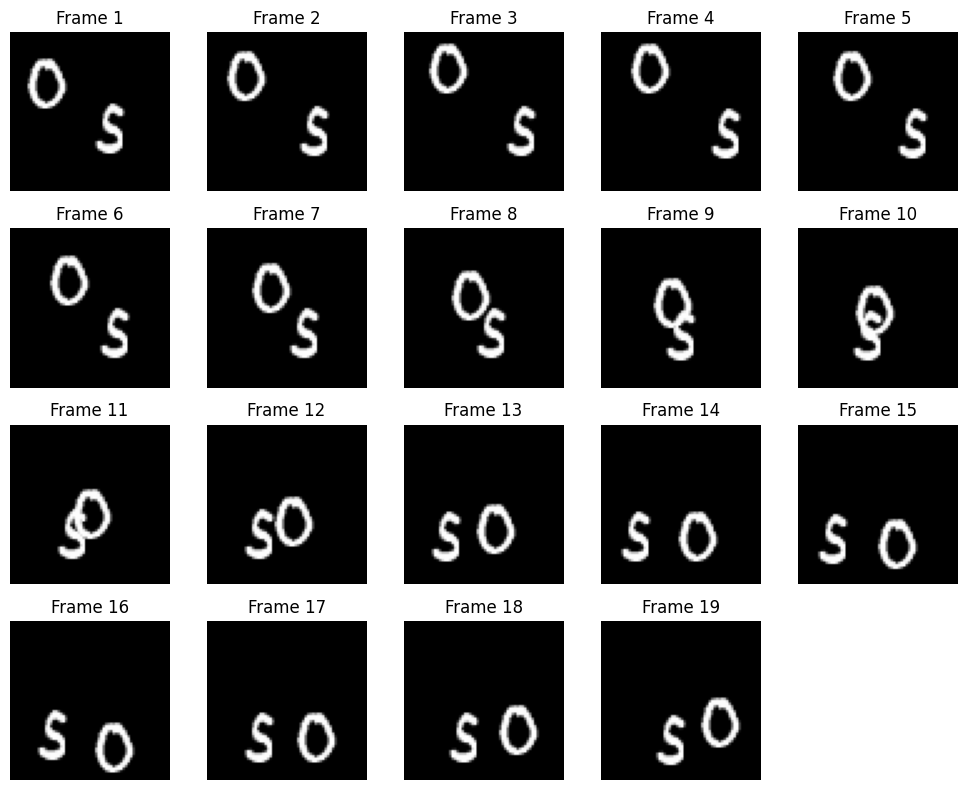

In [8]:
# Construct a figure on which we will visualize the images
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
frames = train_dataset.tensors[0][data_choice]

for idx, ax in enumerate(axes.flat):
    if idx < frames.shape[0]:
        frame = frames[idx].squeeze().numpy()
        ax.imshow(frame, cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.axis("off")
    else:
        ax.axis("off")

# Print information and display the figure
print(f"Displaying frames for example {data_choice}.")
plt.tight_layout()
plt.show()

In [9]:
# Define the Encoder module
class Encoder(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv3d(input_shape[3], 64, kernel_size=(3, 5, 5), padding=(1, 2, 2), stride=(1, 2, 2))
        self.bn1 = nn.BatchNorm3d(64)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1), stride=(1, 2, 2))
        self.bn2 = nn.BatchNorm3d(128)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1), stride=(1, 2, 2))
        self.bn3 = nn.BatchNorm3d(256)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(256 * input_shape[0] * input_shape[1] // 8 * input_shape[2] // 8, latent_dim)

    def forward(self, x):
        x = x.permute(0, 4, 1, 2, 3)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.flatten(x)
        z = self.dense1(x)
        return z

# Define the Decoder module
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super(Decoder, self).__init__()
        self.dense1 = nn.Linear(latent_dim, 256 * output_shape[0] * output_shape[1] // 8 * output_shape[2] // 8)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, output_shape[0], output_shape[1] // 8, output_shape[2] // 8))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1), stride=(1, 2, 2), output_padding=(0, 1, 1))
        self.bn1 = nn.BatchNorm3d(128)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1), stride=(1, 2, 2), output_padding=(0, 1, 1))
        self.bn2 = nn.BatchNorm3d(64)
        self.deconv3 = nn.ConvTranspose3d(64, output_shape[3], kernel_size=(3, 3, 3), padding=(1, 1, 1), stride=(1, 2, 2), output_padding=(0, 1, 1))

    def forward(self, z):
        z = self.dense1(z)
        z = self.unflatten(z)
        z = torch.relu(self.bn1(self.deconv1(z)))
        z = torch.relu(self.bn2(self.deconv2(z)))
        recon_x = torch.sigmoid(self.deconv3(z))
        recon_x = recon_x.permute(0, 2, 3, 4, 1)  # Rearrange dimensions back to (batch_size, frames, height, width, channels)
        return recon_x

# Define the AE module
class AE(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(AE, self).__init__()
        self.encoder = Encoder(input_shape, latent_dim)
        self.decoder = Decoder(latent_dim, input_shape)

    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        return recon_x

In [10]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
input_shape = x_train.shape[1:]
latent_dim = 10
model = AE(input_shape, latent_dim).to(device)

In [11]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

encoder.conv1.weight tensor([[[[[-0.0053, -0.0731,  0.0437, -0.0227,  0.1088],
           [ 0.0033,  0.0879,  0.0147,  0.0023,  0.0126],
           [ 0.0504, -0.0192,  0.0153, -0.0972, -0.0837],
           [ 0.0451,  0.1045,  0.0397, -0.0460,  0.0899],
           [-0.0474, -0.0491,  0.0392, -0.0812,  0.0043]],

          [[-0.0207, -0.0736, -0.0444,  0.0066, -0.0552],
           [ 0.0794,  0.0978, -0.0587,  0.0698,  0.0513],
           [ 0.0669, -0.0078,  0.0298, -0.0385, -0.0970],
           [ 0.1132,  0.1084,  0.0116, -0.0367, -0.0193],
           [-0.0955,  0.1047,  0.0222,  0.0158,  0.1055]],

          [[ 0.0947, -0.1047,  0.0881, -0.1147, -0.0294],
           [ 0.1036, -0.0542,  0.0187, -0.0991,  0.0002],
           [-0.0307, -0.0766,  0.0723,  0.0695,  0.0153],
           [ 0.0826,  0.0308, -0.0257,  0.0331,  0.0381],
           [-0.0905,  0.0749,  0.1144,  0.0506, -0.0695]]]],



        [[[[-0.0605,  0.0775,  0.1073,  0.1031, -0.0302],
           [ 0.0256, -0.0786, -0.0933,  0

In [12]:
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Define the loss function for AE
def ae_loss(x, recon_x):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    return recon_loss

# Train the AE model
def train(model, train_dataloader, val_dataloader, optimizer, epochs, device):
    model.train()
    scaler = GradScaler()  # Initialize GradScaler
    best_loss = float('inf')
    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in pbar:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            # Use autocast for mixed precision training
            with autocast():
                recon_x = model(batch)
                loss = ae_loss(batch, recon_x)
            # Scale the loss and call backward() to create scaled gradients
            scaler.scale(loss).backward()
            # Unscales the gradients of optimizer's assigned params in-place and call step() to update params
            scaler.step(optimizer)
            # Updates the scale for next iteration
            scaler.update()
            total_loss += loss.item()
            pbar.set_postfix({'loss': total_loss / (pbar.n + 1)})
        avg_loss = total_loss / len(train_dataloader)
        writer.add_scalar('Loss/train', avg_loss, epoch)  # Log the average loss for this epoch

        # Validate and save the best model every 10 epochs
        if epoch % 10 == 0:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch = batch[0].to(device)
                    recon_x = model(batch)
                    loss = ae_loss(batch, recon_x)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_dataloader)
            writer.add_scalar('Loss/val', avg_val_loss, epoch)  # Log the average validation loss for this epoch
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "movingmnist_ae_best.pth")
            model.train()

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the model
input_shape = x_train.shape[1:]
latent_dim = 20
model = AE(input_shape, latent_dim).to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=1e-6)

# Train the model
epochs = 100
train(model, train_loader, val_loader, optimizer, epochs, device)
writer.close()

Epoch 100/100: 100%|██████████| 71/71 [00:14<00:00,  4.79it/s, loss=4.33e+6]


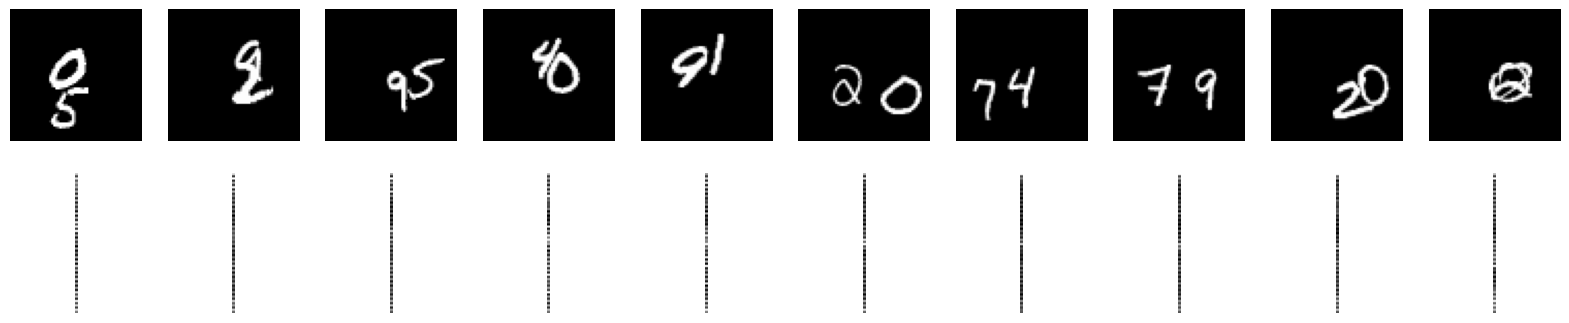

In [13]:
# Visualize some example reconstructions
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for examples in val_loader:
        examples = examples[0].to(device)
        *_, recon_examples = model(examples)
        break

examples = examples.cpu().numpy()
recon_examples = recon_examples.cpu().numpy()

fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    axes[0, i].imshow(examples[i, 0], cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_examples[i, 0], cmap='gray')
    axes[1, i].axis('off')
plt.show()